In [292]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [293]:
#!pip install git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git

In [294]:
 from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

In [295]:
#import spacy
#!python -m spacy download fr_core_news_md

In [296]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
import re

In [297]:
import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from scipy import sparse
# load joblib module for files import/export with possible compression
import joblib
import os

In [298]:
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

In [299]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import warnings

#I. First steps and texts /titles import (900 texts)

In [300]:
my_path = '/content/drive/My Drive/Colab Notebooks/nuitducode/full_texts-20211015T182201Z-001/full_texts'
my_path_csv = '/content/drive/My Drive/Colab Notebooks/nuitducode'

In [301]:
os.path.exists(my_path)

True

In [302]:
df_textes = pd.DataFrame(columns=['name_file', 'content'])

In [303]:
for a, (root, dirs, files) in enumerate (os.walk(my_path)):
    print (a)
    for i,j in enumerate(files):

        df_textes.loc[i,'name_file'] = files[i]
        with open(os.path.join(my_path, j),'r') as f:
            data = f.read()
            df_textes.loc[i, 'content'] = data


0


In [304]:
df_titres = pd.read_csv(os.path.join(my_path_csv, 'textes.csv'))

In [305]:
df_titres

,id,emetteur,nature,titre
0,JORFTEXT000044162822,Ministère de l'Europe et des affaires étrangères,ARRETE,Arrêté du 1er octobre 2021 fixant le nombre de...
1,JORFTEXT000044162827,Ministère de l'Europe et des affaires étrangères,ARRETE,Arrêté du 1er octobre 2021 fixant le nombre de...
2,JORFTEXT000044162833,Ministère de la transition écologique,ARRETE,Arrêté du 23 septembre 2021 portant déclaratio...
3,JORFTEXT000044162840,Ministère de la transition écologique,ARRETE,Arrêté du 28 septembre 2021 relatif aux contrô...
4,JORFTEXT000044162888,"Ministère de l'économie, des finances et de la...",ARRETE,Arrêté du 27 septembre 2021 définissant une li...
...,...,...,...,...
20116,JORFTEXT000042158085,"Ministère de l'enseignement supérieur, de la r...",ARRETE,Arrêté du 21 juillet 2020 modifiant l'arrêté d...
20117,JORFTEXT000042158192,Commission nationale de l'informatique et des ...,DELIBERATION,Délibération n° 2020-076 du 18 juin 2020 porta...
20118,JORFTEXT000042158203,Commission nationale de l'informatique et des ...,DELIBERATION,Délibération n° 2020-077 du 18 juin 2020 porta...
20119,JORFTEXT000042158211,Commission nationale de l'informatique et des ...,DELIBERATION,Délibération n° 2020-081 du 18 juin 2020 porta...


In [306]:
df_textes['id'] = df_textes.name_file.str.replace('.txt', '')

In [307]:
df = pd.merge(df_textes, df_titres, how = 'left', on='id')

In [308]:
df

,name_file,content,id,emetteur,nature,titre
0,JORFTEXT000042157732.txt,En application des \ndispositions de l'article...,JORFTEXT000042157732,"Ministère de l'économie, des finances et de la...",ARRETE,Arrêté du 13 juillet 2020 accordant la garanti...
1,JORFTEXT000042157705.txt,L'annexe de l'arrêté du 17 janvier 2019 susvis...,JORFTEXT000042157705,"Ministère de l'éducation nationale, de la jeun...",ARRETE,Arrêté du 17 juillet 2020 modifiant l'arrêté d...
2,JORFTEXT000042157644.txt,Le commissaire en chef de 1re classe Jean LE R...,JORFTEXT000042157644,NaN,ARRETE,Arrêté du 27 juillet 2020 portant nomination à...
3,JORFTEXT000042157698.txt,A l'article 1er de l'arrêté du 22 juillet 2019...,JORFTEXT000042157698,"Ministère de l'éducation nationale, de la jeun...",ARRETE,Arrêté du 17 juillet 2020 modifiant l'arrêté d...
4,JORFTEXT000042157710.txt,L'annexe de l'arrêté du 18 février 2015 susvis...,JORFTEXT000042157710,"Ministère de l'éducation nationale, de la jeun...",ARRETE,Arrêté du 17 juillet 2020 modifiant l'arrêté d...
...,...,...,...,...,...,...
925,JORFTEXT000042220181.txt,Par application des \ndispositions de l'articl...,JORFTEXT000042220181,Autorité de contrôle prudentiel,AVIS,Avis relatif à un transfert de portefeuille de...
926,JORFTEXT000042220177.txt,Par application des dispositions des articles ...,JORFTEXT000042220177,Autorité de contrôle prudentiel,AVIS,Avis relatif à une fusion avec transfert de po...
927,JORFTEXT000042220140.txt,En application de l'\narticle L. 2261-15 du co...,JORFTEXT000042220140,"Ministère du travail, de l'emploi et de l'inse...",AVIS,Avis relatif à l'extension d'un avenant à un a...
928,JORFTEXT000042220134.txt,En application de l'\narticle L. 2261-15 du co...,JORFTEXT000042220134,"Ministère du travail, de l'emploi et de l'inse...",AVIS,Avis relatif à l'extension d'un accord conclu ...


# II. Copy of main DataFrame and texts transformation

In [309]:
df_data = df.copy()

In [310]:
df_data['content'] = df_data.content.str.lower()
df_data['titre'] = df_data.titre.str.lower()

## Tokenization

In [311]:
RegExp = r'[a-zàâçéèêëîïôûùüÿñæœ]+' #Tous les caractères utf 8 ou presque
tokenizer0 = nltk.RegexpTokenizer(RegExp) 

In [312]:
f_data['doc_tokenized'] = df_data['content'].apply(tokenizer0.tokenize)
df_data['titre_token'] = df_data.titre.apply(tokenizer0.tokenize)

In [313]:
df_data[['doc_tokenized', 'titre_token'] ]

,doc_tokenized,titre_token
0,"[en, application, des, dispositions, de, l, ar...","[arrêté, du, juillet, accordant, la, garantie,..."
1,"[l, annexe, de, l, arrêté, du, janvier, susvis...","[arrêté, du, juillet, modifiant, l, arrêté, du..."
2,"[le, commissaire, en, chef, de, re, classe, je...","[arrêté, du, juillet, portant, nomination, à, ..."
3,"[a, l, article, er, de, l, arrêté, du, juillet...","[arrêté, du, juillet, modifiant, l, arrêté, du..."
4,"[l, annexe, de, l, arrêté, du, février, susvis...","[arrêté, du, juillet, modifiant, l, arrêté, du..."
...,...,...
925,"[par, application, des, dispositions, de, l, a...","[avis, relatif, à, un, transfert, de, portefeu..."
926,"[par, application, des, dispositions, des, art...","[avis, relatif, à, une, fusion, avec, transfer..."
927,"[en, application, de, l, article, l, du, code,...","[avis, relatif, à, l, extension, d, un, avenan..."
928,"[en, application, de, l, article, l, du, code,...","[avis, relatif, à, l, extension, d, un, accord..."


## stopwords

In [314]:
#stopwords
st_w=nltk.corpus.stopwords.words('french')
def remove_stop_word(list_, stopwords):
    return [c for c in list_ if not c in stopwords]

In [315]:
#let's apply this function now
df_data['doc_tokenized'] = df_data['doc_tokenized'].apply(lambda x: remove_stop_word(x,st_w))
df_data['titre_token'] = df_data['titre_token'].apply(lambda x: remove_stop_word(x,st_w))

In [316]:
df_data

,name_file,content,id,emetteur,nature,titre,doc_tokenized,titre_token
0,JORFTEXT000042157732.txt,en application des \ndispositions de l'article...,JORFTEXT000042157732,"Ministère de l'économie, des finances et de la...",ARRETE,arrêté du 13 juillet 2020 accordant la garanti...,"[application, dispositions, article, loi, mars...","[arrêté, juillet, accordant, garantie, etat, é..."
1,JORFTEXT000042157705.txt,l'annexe de l'arrêté du 17 janvier 2019 susvis...,JORFTEXT000042157705,"Ministère de l'éducation nationale, de la jeun...",ARRETE,arrêté du 17 juillet 2020 modifiant l'arrêté d...,"[annexe, arrêté, janvier, susvisé, modifiée, c...","[arrêté, juillet, modifiant, arrêté, janvier, ..."
2,JORFTEXT000042157644.txt,le commissaire en chef de 1re classe jean le r...,JORFTEXT000042157644,NaN,ARRETE,arrêté du 27 juillet 2020 portant nomination à...,"[commissaire, chef, re, classe, jean, roch, no...","[arrêté, juillet, portant, nomination, préside..."
3,JORFTEXT000042157698.txt,a l'article 1er de l'arrêté du 22 juillet 2019...,JORFTEXT000042157698,"Ministère de l'éducation nationale, de la jeun...",ARRETE,arrêté du 17 juillet 2020 modifiant l'arrêté d...,"[a, article, er, arrêté, juillet, susvisé, lig...","[arrêté, juillet, modifiant, arrêté, juillet, ..."
4,JORFTEXT000042157710.txt,l'annexe de l'arrêté du 18 février 2015 susvis...,JORFTEXT000042157710,"Ministère de l'éducation nationale, de la jeun...",ARRETE,arrêté du 17 juillet 2020 modifiant l'arrêté d...,"[annexe, arrêté, février, susviséest, remplacé...","[arrêté, juillet, modifiant, arrêté, février, ..."
...,...,...,...,...,...,...,...,...
925,JORFTEXT000042220181.txt,par application des \ndispositions de l'articl...,JORFTEXT000042220181,Autorité de contrôle prudentiel,AVIS,avis relatif à un transfert de portefeuille de...,"[application, dispositions, article, code, mut...","[avis, relatif, transfert, portefeuille, bulle..."
926,JORFTEXT000042220177.txt,par application des dispositions des articles ...,JORFTEXT000042220177,Autorité de contrôle prudentiel,AVIS,avis relatif à une fusion avec transfert de po...,"[application, dispositions, articles, code, mu...","[avis, relatif, fusion, transfert, portefeuill..."
927,JORFTEXT000042220140.txt,en application de l'\narticle l. 2261-15 du co...,JORFTEXT000042220140,"Ministère du travail, de l'emploi et de l'inse...",AVIS,avis relatif à l'extension d'un avenant à un a...,"[application, article, code, travail, ministre...","[avis, relatif, extension, avenant, accord, co..."
928,JORFTEXT000042220134.txt,en application de l'\narticle l. 2261-15 du co...,JORFTEXT000042220134,"Ministère du travail, de l'emploi et de l'inse...",AVIS,avis relatif à l'extension d'un accord conclu ...,"[application, article, code, travail, ministre...","[avis, relatif, extension, accord, conclu, sec..."


## lemmatization

In [318]:
lemmatizer = FrenchLefffLemmatizer()

In [319]:
def lemmatize_list(List_):
    d=[]

    for c in List_:
            d = d + [lemmatizer.lemmatize(c)]
    return d

In [320]:
lemmatizer.lemmatize('mentionnées')

'mentionnées'

In [321]:
df_data['doc_tokenized'] = df_data['doc_tokenized'].apply(lemmatize_list)
df_data['titre_token'] = df_data['titre_token'].apply(lemmatize_list)

In [322]:
df_data

,name_file,content,id,emetteur,nature,titre,doc_tokenized,titre_token
0,JORFTEXT000042157732.txt,en application des \ndispositions de l'article...,JORFTEXT000042157732,"Ministère de l'économie, des finances et de la...",ARRETE,arrêté du 13 juillet 2020 accordant la garanti...,"[application, disposition, article, loi, mar, ...","[arrêté, juillet, accordant, garantie, etat, é..."
1,JORFTEXT000042157705.txt,l'annexe de l'arrêté du 17 janvier 2019 susvis...,JORFTEXT000042157705,"Ministère de l'éducation nationale, de la jeun...",ARRETE,arrêté du 17 juillet 2020 modifiant l'arrêté d...,"[annexe, arrêté, janvier, susvisé, modifiée, c...","[arrêté, juillet, modifiant, arrêté, janvier, ..."
2,JORFTEXT000042157644.txt,le commissaire en chef de 1re classe jean le r...,JORFTEXT000042157644,NaN,ARRETE,arrêté du 27 juillet 2020 portant nomination à...,"[commissaire, chef, re, classe, jean, roch, no...","[arrêté, juillet, portant, nomination, préside..."
3,JORFTEXT000042157698.txt,a l'article 1er de l'arrêté du 22 juillet 2019...,JORFTEXT000042157698,"Ministère de l'éducation nationale, de la jeun...",ARRETE,arrêté du 17 juillet 2020 modifiant l'arrêté d...,"[a, article, er, arrêté, juillet, susvisé, lig...","[arrêté, juillet, modifiant, arrêté, juillet, ..."
4,JORFTEXT000042157710.txt,l'annexe de l'arrêté du 18 février 2015 susvis...,JORFTEXT000042157710,"Ministère de l'éducation nationale, de la jeun...",ARRETE,arrêté du 17 juillet 2020 modifiant l'arrêté d...,"[annexe, arrêté, février, susviséest, remplacé...","[arrêté, juillet, modifiant, arrêté, février, ..."
...,...,...,...,...,...,...,...,...
925,JORFTEXT000042220181.txt,par application des \ndispositions de l'articl...,JORFTEXT000042220181,Autorité de contrôle prudentiel,AVIS,avis relatif à un transfert de portefeuille de...,"[application, disposition, article, code, mutu...","[avis, relatif, transfert, portefeuille, bulle..."
926,JORFTEXT000042220177.txt,par application des dispositions des articles ...,JORFTEXT000042220177,Autorité de contrôle prudentiel,AVIS,avis relatif à une fusion avec transfert de po...,"[application, disposition, article, code, mutu...","[avis, relatif, fusion, transfert, portefeuill..."
927,JORFTEXT000042220140.txt,en application de l'\narticle l. 2261-15 du co...,JORFTEXT000042220140,"Ministère du travail, de l'emploi et de l'inse...",AVIS,avis relatif à l'extension d'un avenant à un a...,"[application, article, code, travail, ministre...","[avis, relatif, extension, avenant, accord, co..."
928,JORFTEXT000042220134.txt,en application de l'\narticle l. 2261-15 du co...,JORFTEXT000042220134,"Ministère du travail, de l'emploi et de l'inse...",AVIS,avis relatif à l'extension d'un accord conclu ...,"[application, article, code, travail, ministre...","[avis, relatif, extension, accord, conclu, sec..."


## Word count: visualization

In [323]:
fdist = nltk.FreqDist(df_data.doc_tokenized.explode()) #we take all questions
df_words_texte = pd.DataFrame(columns=['word','tot_count'])
df_words_texte['word'] = fdist.keys()
df_words_texte['tot_count'] = fdist.values()
df_words_texte = df_words_texte.sort_values(by=['tot_count','word'], ascending = False).reset_index(drop=True)

fdist = nltk.FreqDist(df_data.titre_token.explode())
df_words_titre = pd.DataFrame(columns=['word','tot_count'])
df_words_titre['word'] = fdist.keys()
df_words_titre['tot_count'] = fdist.values()
df_words_titre = df_words_titre.sort_values(by=['tot_count','word'], ascending = False).reset_index(drop=True)


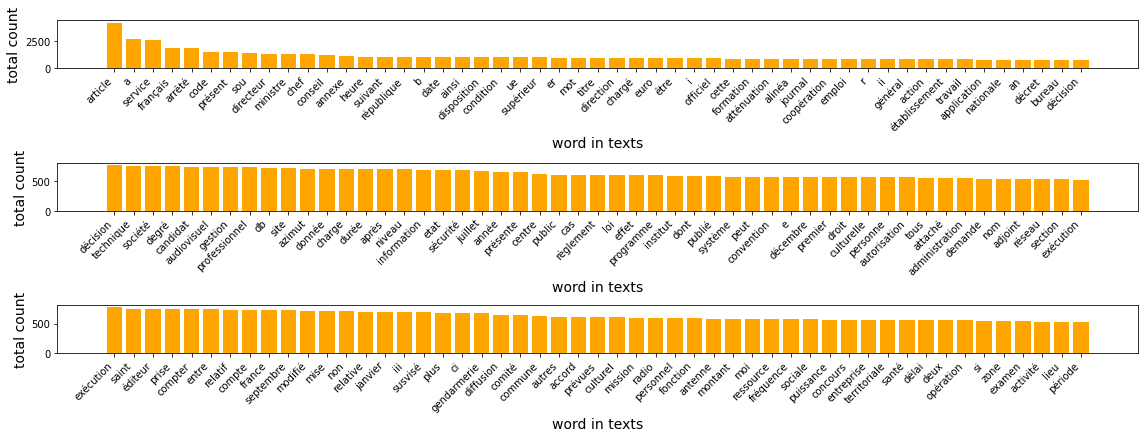

In [324]:
fig, ax0 = plt.subplots(3,1)

fig.set_size_inches(16,6)

ax = plt.subplot(311)
plt.bar(x=df_words_texte.loc[0:50,'word'] , height=df_words_texte.loc[0:50,'tot_count'], color="orange")

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(df_words_texte.loc[0:50,'word'] , rotation = 45, horizontalalignment = 'right')
ax.set_xlabel('word in texts', size=14)
ax.set_ylabel('total count', size=14)

ax = plt.subplot(312)
plt.bar(x=df_words_texte.loc[50:100,'word'] , height=df_words_texte.loc[50:100,'tot_count'], color="orange")

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(df_words_texte.loc[50:100,'word'] , rotation = 45, horizontalalignment = 'right')
ax.set_xlabel('word in texts', size=14)
ax.set_ylabel('total count', size=14)

ax = plt.subplot(313)
plt.bar(x=df_words.loc[50:100,'word'] , height=df_words_texte.loc[50:100,'tot_count'], color="orange")

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(df_words_texte.loc[100:150,'word'] , rotation = 45, horizontalalignment = 'right')
ax.set_xlabel('word in texts', size=14)
ax.set_ylabel('total count', size=14)

plt.tight_layout();

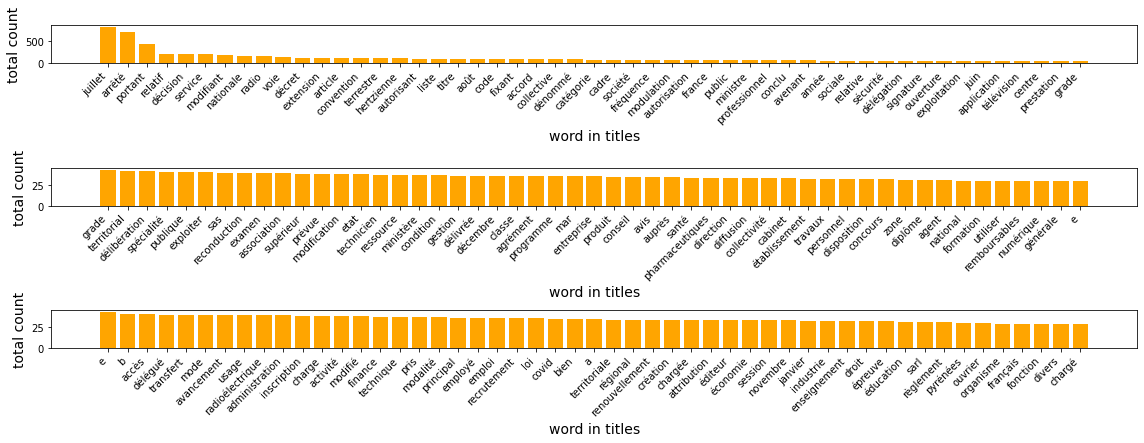

In [325]:
fig, ax0 = plt.subplots(3,1)

fig.set_size_inches(16,6)

ax = plt.subplot(311)
plt.bar(x=df_words_titre.loc[0:50,'word'] , height=df_words_titre.loc[0:50,'tot_count'], color="orange")

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(df_words_titre.loc[0:50,'word'] , rotation = 45, horizontalalignment = 'right')
ax.set_xlabel('word in titles', size=14)
ax.set_ylabel('total count', size=14)

ax = plt.subplot(312)
plt.bar(x=df_words_titre.loc[50:100,'word'] , height=df_words_titre.loc[50:100,'tot_count'], color="orange")

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(df_words_titre.loc[50:100,'word'] , rotation = 45, horizontalalignment = 'right')
ax.set_xlabel('word in titles', size=14)
ax.set_ylabel('total count', size=14)

ax = plt.subplot(313)
plt.bar(x=df_words_titre.loc[50:100,'word'] , height=df_words_titre.loc[50:100,'tot_count'], color="orange")

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(df_words_titre.loc[100:150,'word'] , rotation = 45, horizontalalignment = 'right')
ax.set_xlabel('word in titles', size=14)
ax.set_ylabel('total count', size=14)

plt.tight_layout();

In [326]:
df_words_texte['length'] = df_words_texte.word.str.len()

## stop words 2 : new stop words added (to be optimized)

In [327]:
st2 = df_words_texte.query('length<=3').word #1071

In [328]:
st3 = df_words_texte.word[:101]

In [329]:
ST = st2.values.tolist() + st3.values.tolist() + ['susvisé', 'susvisées', 'susvisée', 'janvier', 'février', 
                                                  'mars', 'avril', 'juin', 'juillet', 'août', 'septembre', 'octobre', 'novembre', 'décembre',
                                                  'mentionné', 'mentionnée', 'mentionnées', 'département', 'renseignement', 'organisation',
                                                  'avis', 'avenant', 'extension', 'accord', 'nommé', 'dénommée', 'susviséest', 'remplacé', 'modifié', 'remplacée', 'modifiée', 'envisage',
                                                  'comformément', 'entre', 'relatif', 'avant', 'toute', 'mesure', 'classe', 'procédure', 'tendant', 'insertion', 'accordé', 'rectificative', 
                                                  'champ', 'collective']
 

In [330]:
#apply st words 2
df_data['doc_tokenized'] = df_data['doc_tokenized'].apply(lambda x: remove_stop_word(x,ST))
df_data['titre_token'] = df_data['titre_token'].apply(lambda x: remove_stop_word(x,ST))

In [331]:
df_data

,name_file,content,id,emetteur,nature,titre,doc_tokenized,titre_token
0,JORFTEXT000042157732.txt,en application des \ndispositions de l'article...,JORFTEXT000042157732,"Ministère de l'économie, des finances et de la...",ARRETE,arrêté du 13 juillet 2020 accordant la garanti...,"[finance, garantie, paribas, crédit, lyonnais,...","[accordant, garantie, paribas, crédit, lyonnai..."
1,JORFTEXT000042157705.txt,l'annexe de l'arrêté du 17 janvier 2019 susvis...,JORFTEXT000042157705,"Ministère de l'éducation nationale, de la jeun...",ARRETE,arrêté du 17 juillet 2020 modifiant l'arrêté d...,"[comme, suit, deuxième, phrase, troisième, par...","[modifiant, fixant, enseignement, scientifique..."
2,JORFTEXT000042157644.txt,le commissaire en chef de 1re classe jean le r...,JORFTEXT000042157644,NaN,ARRETE,arrêté du 27 juillet 2020 portant nomination à...,"[commissaire, jean, roch, état, major, particu...","[portant, nomination, présidence]"
3,JORFTEXT000042157698.txt,a l'article 1er de l'arrêté du 22 juillet 2019...,JORFTEXT000042157698,"Ministère de l'éducation nationale, de la jeun...",ARRETE,arrêté du 17 juillet 2020 modifiant l'arrêté d...,"[ligne, langue, littérature, culture, étranger...","[modifiant, nature, épreuve, terminale, baccal..."
4,JORFTEXT000042157710.txt,l'annexe de l'arrêté du 18 février 2015 susvis...,JORFTEXT000042157710,"Ministère de l'éducation nationale, de la jeun...",ARRETE,arrêté du 17 juillet 2020 modifiant l'arrêté d...,"[entrent, vigueur, compter, rentrée, scolaire]","[modifiant, fixant, enseignement, école, mater..."
...,...,...,...,...,...,...,...,...
925,JORFTEXT000042220181.txt,par application des \ndispositions de l'articl...,JORFTEXT000042220181,Autorité de contrôle prudentiel,AVIS,avis relatif à un transfert de portefeuille de...,"[mutualité, mutuelle, mutuelle, constructeur, ...","[transfert, portefeuille, bulletin, adhésion, ..."
926,JORFTEXT000042220177.txt,par application des dispositions des articles ...,JORFTEXT000042220177,Autorité de contrôle prudentiel,AVIS,avis relatif à une fusion avec transfert de po...,"[mutualité, union, mutuelle, union, mutuelle, ...","[fusion, transfert, portefeuille, bulletin, ad..."
927,JORFTEXT000042220140.txt,en application de l'\narticle l. 2261-15 du co...,JORFTEXT000042220140,"Ministère du travail, de l'emploi et de l'inse...",AVIS,avis relatif à l'extension d'un avenant à un a...,"[prendre, rendre, obligatoires, employeur, sal...","[conclu, cadre, entreprise, artistiques, cultu..."
928,JORFTEXT000042220134.txt,en application de l'\narticle l. 2261-15 du co...,JORFTEXT000042220134,"Ministère du travail, de l'emploi et de l'inse...",AVIS,avis relatif à l'extension d'un accord conclu ...,"[prendre, rendre, obligatoires, employeur, sal...","[conclu, secteur, industrie, maroquinerie, voy..."


## Word count visualization 2

In [332]:
fdist = nltk.FreqDist(df_data.doc_tokenized.explode()) #we take all questions
df_words_texte = pd.DataFrame(columns=['word','tot_count'])
df_words_texte['word'] = fdist.keys()
df_words_texte['tot_count'] = fdist.values()
df_words_texte = df_words_texte.sort_values(by=['tot_count','word'], ascending = False).reset_index(drop=True)


In [333]:
df_words_texte

,word,tot_count
0,saint,524
1,éditeur,523
2,prise,522
3,compter,522
4,compte,513
...,...,...
15891,abaissé,1
15892,abadie,1
15893,aarau,1
15894,aambc,1


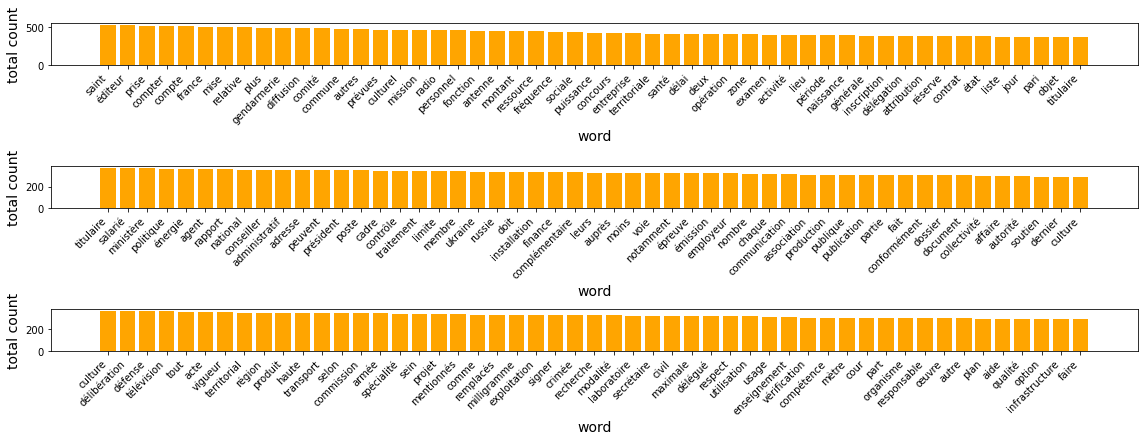

In [334]:
fig, ax0 = plt.subplots(3,1)

fig.set_size_inches(16,6)

ax = plt.subplot(311)
plt.bar(x=df_words_texte.loc[0:50,'word'] , height=df_words_texte.loc[0:50,'tot_count'], color="orange")

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(df_words_texte.loc[0:50,'word'] , rotation = 45, horizontalalignment = 'right')
ax.set_xlabel('word', size=14)
ax.set_ylabel('total count', size=14)

ax = plt.subplot(312)
plt.bar(x=df_words_texte.loc[50:100,'word'] , height=df_words_texte.loc[50:100,'tot_count'], color="orange")

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(df_words_texte.loc[50:100,'word'] , rotation = 45, horizontalalignment = 'right')
ax.set_xlabel('word', size=14)
ax.set_ylabel('total count', size=14)

ax = plt.subplot(313)
plt.bar(x=df_words_texte.loc[50:100,'word'] , height=df_words_texte.loc[50:100,'tot_count'], color="orange")

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(df_words_texte.loc[100:150,'word'] , rotation = 45, horizontalalignment = 'right')
ax.set_xlabel('word', size=14)
ax.set_ylabel('total count', size=14)

plt.tight_layout();

# Count vectorizer (to summarize all the former steps) + generation of tf

In [335]:
def my_preprocessor(doc):
    return(doc.lower())

def my_tokenizer(s):
    Step1 = tokenizer0.tokenize(s)
    Step2 = remove_stop_word(Step1, st_w)
    Step3 = lemmatize_list(Step2)
    Step4 = remove_stop_word(Step3, ST)
    return Step4




In [336]:
CVect = CountVectorizer(preprocessor = my_preprocessor, tokenizer = my_tokenizer, stop_words = None, token_pattern = None)

In [337]:
tf = CVect.fit_transform(df_data.content)
tf

<930x15896 sparse matrix of type '<class 'numpy.int64'>'
	with 89542 stored elements in Compressed Sparse Row format>

In [338]:
df_list_words_2 = pd.DataFrame(columns=['word','tot_count'])
df_list_words_2['word'] = CVect.get_feature_names() 

#tf being a compressed sparse matrix under format csr, we use the sparse matrix function sum to get the terms frequency
# we transform it into a array so that we can populate our second column of our dataset
df_list_words_2['tot_count'] = np.asarray((tf.sum(axis=0))).reshape(-1)

#sorting
df_list_words_2_sorted = df_list_words_2.sort_values(by=['tot_count','word'], ascending = False).reset_index(drop = True)

In [339]:
df_list_words_2_sorted

,word,tot_count
0,saint,524
1,éditeur,523
2,prise,522
3,compter,522
4,compte,513
...,...,...
15891,abaissé,1
15892,abadie,1
15893,aarau,1
15894,aambc,1


In [340]:
list_words = CVect.get_feature_names()

## tf idf generation with TfIdfTransformer

In [341]:
transformer = TfidfTransformer(smooth_idf=False)
tfidf =  transformer.fit_transform(tf) #sparse matrix array

#Useful functions for display and Tags Generation

In [342]:
#function which select best x topics for question ix, and then retrieve best words (tags) associated to the selected topics
def retrieve_tags_from_question(doc_index, df_doc_topics, df_topics_words, nb_topics = 3, nb_words = 1):

    #indices of best topics to consider for the document (question) index
    best_topics_ix = df_doc_topics.loc[doc_index,:].argsort()[:-1-nb_topics:-1].values.tolist()
    #part of  the topic/word dataset limited to best topics
    Topic_Words_df = df_topics_words.loc[best_topics_ix,:]
    Tags_=[]
    for best_topic in best_topics_ix:
        Tag_indices = Topic_Words_df.loc[best_topic,:].argsort()[:-1-nb_words:-1]
        Tags_ = Tags_ + [list_words[tag] for tag in Tag_indices]
    
    return Tags_ #returns a list of best tags

**Main Words distribution among topics**

In [343]:
#function calculating the list of words represented among TOP_W top words of all topics, 
#and how many times they are represented.
#output is a 1 column dataframe with a list of words in index, and the occurences count in values

def calculate_top_words_count(df_topic_words, TOP_W = 5):
    #nlargest(TOP_W).index get the TOP_W words per topic (row) in a list of TOP_W words
    Y=pd.DataFrame(df_topic_words).apply(lambda x: x.nlargest(TOP_W).index.tolist(), axis=1)
    #dummificator with list words as an input
    mlb = MultiLabelBinarizer()
    mlb.fit([list_words]) 
    #transform Y into a dummy matrix with one word per column and do the sum. => we get our words count in a serie
    Y2=pd.DataFrame(mlb.transform(Y), columns=list_words).sum().sort_values(ascending = False) 
    #Serie to dataset filtering on words_count >0
    Y3 = pd.DataFrame(Y2, columns=['words_count']).query("words_count>0")
    
    return Y3

**document _ topic distribution display**

In [344]:
#function displaying graphically for each question, the topT topics and their probability
def display_topx_topics_per_question(df_doc_topics, ncols = 10, TopT = 5, question_min=0, nb_questions = 20, random = False):

    nrows = int(np.ceil(nb_questions/ncols))

    plt.subplots(nrows, ncols)
    plt.gcf().set_size_inches(16, 2 * nrows)
    
    if random:
        qu_range = np.random.choice(range(0, df_doc_topics.shape[0]), nb_questions)
    else:
        qu_range = range(question_min,question_min+nb_questions)
    
    for i in range(0,nb_questions): 
        j = qu_range[i] #j = question_id
        DF_TOP_TOPICS = df_doc_topics.iloc[j].sort_values(ascending = False).head(TopT)
        
        ax = plt.subplot(nrows, ncols, i+1)
        
        plt.bar(x= range(0,TopT), height = DF_TOP_TOPICS.values, color='#E1C70C')
        ax.set_xticks(range(0,TopT))
        ax.set_xticklabels(DF_TOP_TOPICS.index, rotation=30, size=10)
        #plt.setp(ax.get_xticklabels(), ha='right', rotation=30, size=14)
        ax.set_title('qu. n°' + str(j), size=12)
        ax.set_xlabel('topic id', size=12)
        ax.set_ylabel('topic probability', size=12)

    plt.tight_layout(w_pad = 1.5, h_pad = 1) 

In [345]:
#function displaying graphically how many questions have the topic x as the top topic

def display_top_topic_count(df_doc_topics, nbars = 50):

    Y = pd.DataFrame(df_doc_topics.idxmax(axis=1), columns=['topic_id'])
    Y['count_val'] = 1
    Y = Y.groupby('topic_id').count().sort_values(by='count_val', ascending=  False)
    n_topics = Y.shape[0]
    
    if nbars>n_topics: nbars=n_topics
    
    nrows = int(np.ceil(n_topics/nbars))
    
    plt.subplots(nrows, 1)
    plt.gcf().set_size_inches(16, 5 * nrows)
    
    for i in range(0, nrows):
        ax = plt.subplot(nrows, 1, i+1)        
        if n_topics >= (i+1)*nbars:
            index_range = range(i*nbars, (i+1)*nbars)
            x_range = range(0, nbars)
        else:
            index_range = range(i*nbars, n_topics)
            x_range = range(0, n_topics - nbars)
        
        plt.bar(x = x_range, height = Y.iloc[index_range,0].values, color="#FF9E00")
 
        ax.set_xticks(x_range)
        ax.set_xticklabels(Y.iloc[index_range].index, rotation=20, size=9)
        ax.set_xlabel ('top topic id', size=14)
        ax.set_ylabel ('nb of questions', size = 14)
        ax.set_title  ('nb of questions where topic n°id is main, per topic id', size=16)
        
        YLIM   = 1.25 * max(Y.iloc[index_range,0].values)
        yticks = ax.get_yticks()
        if df_doc_topics.shape[0]<YLIM:
            print(df_doc_topics.shape[0])
            YLIM = 5000 * np.ceil(df_doc_topics.shape[0]/5000)
            yticks = np.append(np.delete(ax.get_yticks(), ax.get_yticks().size - 1), df_doc_topics.shape[0])
            plt.axhline(y = df_doc_topics.shape[0],xmin = 0, xmax = 1, color='red') 
            plt.text(x = -0.25, y=1.02*df_doc_topics.shape[0], s='tot nb of questions: {0}'.format(df_doc_topics.shape[0]))
        
        ax.set_yticks(yticks)
        ax.set_yticklabels(["{0:g}".format(c) for c in yticks], size=12)
        ax.set_ylim(0, YLIM )
        ax.set_xlim(-1, max(x_range)+1)
        
        ax2 = ax.twinx()
        ax2.set_ylim(0,100 * ax.get_ylim()[1] /df_doc_topics.shape[0] )
        #ax2.set_yticks(range(0,110,20))
        #ax2.set_yticklabels (['{0}%'.format(c) for c in ax2.get_yticks()], size = 12, rotation = 0)
        ax2.set_ylabel ('%', size = 14, rotation = 0)
        ax .grid(axis='y', linewidth = 0.25, color='#6EA599')
        ax2.grid(axis='y', color = '#06B990', ls='--', linewidth=0.5)
        
        
        
    plt.tight_layout(w_pad = 1, h_pad = 1) 

**topic word display**

In [346]:
#function displaying graphically, for each topic identified, the TOP W  words

def display_topW_words_per_topic(df_topic_words, ncols = 5, TopW = 5, topic_min=0, nb_topics = 10, random = False):
    
    if topic_min < 0:                                   topic_min = 0
    if topic_min >= df_topic_words.shape[0]:            topic_min = df_topic_words.shape[0] - 1
    if topic_min + nb_topics > df_topic_words.shape[0]: nb_topics = df_topic_words.shape[0] - topic_min
    
    nrows = int(np.ceil(nb_topics/ncols))
    plt.subplots(nrows, ncols)
    plt.gcf().set_size_inches(16, 3 * nrows)
    
    if random:
        topic_range = np.random.choice(range(topic_min, df_topic_words.shape[0]), size = nb_topics, replace = False)
    else:
        if topic_min + nb_topics > df_topic_words.shape[0]: 
            max_t = df_topic_words.shape[0]
        else:
            max_t = topic_min + nb_topics
        
        topic_range = range(topic_min, max_t)
    
    for i in range(0, len(topic_range)):
        j=topic_range[i]
        DF_TOP_WORDS = df_topic_words.iloc[j].sort_values(ascending = False).head(TopW)
        
        ax = plt.subplot(nrows, ncols, 1 + i)
        plt.bar(x= range(0, TopW), height = DF_TOP_WORDS.values, color='#957DE8')
        
        ax.set_xticks(range(0,TopW))
        ax.set_xticklabels([c[0:12] for c in DF_TOP_WORDS.index], rotation=30, size=8, ha='right')
        #plt.setp(ax.get_xticklabels(), ha='right', rotation=30, size=14)
        ax.set_title('topic. n°' + str(j), size=12)
        ax.set_xlabel('top words', size=12)
        ax.set_ylabel('word weight in topic', size=12)

        plt.setp(ax.get_xticklabels(), ha='right', rotation=30, size=14)
        ax.set_title('topic_id ' + str(j), size=16)

    plt.tight_layout(w_pad = 1, h_pad = 1) 

In [347]:
#function displaying graphically the list of words represented among TOP_W top words of all topics, 
#and how many times they are represented.
#in other words : ranked top words, ranking value being the number of occurences in topics having the word w as one of 
#the top 'TOP_W' words

def display_top_words_count_in_topics(df_topic_words, nbars = 50, TOP_W = 5, nb_TOT_words=-1):

    Y3 = calculate_top_words_count(df_topic_words, TOP_W = TOP_W)
    ylim = 1 + Y3.iloc[:,0].max()
    if nb_TOT_words==-1 or nb_TOT_words>Y3.shape[0]: 
        n_words = Y3.shape[0]
    else:      #we take only the first nb TOT words
        n_words = nb_TOT_words
        Y3 = pd.DataFrame(Y3.iloc[0:nb_TOT_words])

    nrows = int(np.ceil(n_words/nbars))
    
    plt.subplots(nrows, 1)
    plt.gcf().set_size_inches(16, 3 * nrows)
    
    for i in range(0, nrows):
        ax = plt.subplot(nrows, 1, i+1)        
        if n_words >= (i+1)*nbars:
            index_range = range(i*nbars, (i+1)*nbars)
        else:
            index_range = range(i*nbars, n_words)

        plt.bar(x = index_range, height = Y3.iloc[index_range,0].values, color="#96A5C1")
        plt.axhline(y = df_topic_words.shape[0], xmin = 0, xmax = 1, color='red')

        plt.setp(ax.get_xticklabels(), rotation=20, size=9)
        ax.set_xticks(index_range)
        ax.set_xticklabels(Y3.iloc[index_range].index, ha='right')
        ax.set_xlabel ('top word', size=12)
        ax.set_ylabel ('count', size = 12)
        ax.set_title  ('nb of occurences in topics ' +  str(TOP_W) + ' top words', size = 16)
        
        
        ax.set_yticks(range(0,ylim))
        ax.set_yticklabels(range(0,ylim), size=12)
        ax .grid(axis='y', linewidth = 0.7, color='#6EA599')
        ax.set_xlim (i*nbars-1, (i+1)*nbars)
        ax.set_ylim (0, ylim) 

        #ax .grid(axis='y', linewidth = 0.25, color='#6EA599')

    plt.tight_layout(w_pad = 1, h_pad = 1) 

**question _ tag distribution display**

In [348]:
#function which displays the count of tags for all questions
def display_tags_count_in_questions(df_doc_topics, df_topic_words, nbars = 50, nb_topics = 1, nb_words = 2):
    
    df_qu_tags = df_data.reset_index()['index'].apply(
        lambda x: retrieve_tags_from_question(x, df_doc_topics, df_topic_words, nb_topics = nb_topics, nb_words = nb_words)
        ).reset_index()
    df_qu_tags.columns = ['question_id', 'Tags']
    df_qu_tags_        = pd.DataFrame(df_qu_tags.Tags.explode())
    df_qu_tags_['Count_Tags'] = 1
    df_countTags       = df_qu_tags_.groupby('Tags').count().sort_values(by='Count_Tags', ascending = False).reset_index()
    #df_countTags has one columns 'Tags' and the other 'Count_Tags'
    
    ntags = df_countTags.shape[0]
    if nbars >= ntags: nbars = ntags
    nrows = int(np.ceil(ntags/nbars))
    
    plt.subplots(nrows, 1)
    plt.gcf().set_size_inches(16, 3 * nrows)
    
    for i in range(0, nrows):
        ax = plt.subplot(nrows, 1, i+1)        
        if ntags >= (i+1)*nbars:
            index_range = range(i*nbars, (i+1)*nbars)
            #ax.set_xlim (i*nbars-1, (i+1)*nbars)
        else:
            index_range = range(i*nbars, ntags)
            #ax.set_xlim (i*nbars-1, ntags)

        plt.bar(x = df_countTags.loc[index_range, 'Tags'], height = df_countTags.loc[index_range, 'Count_Tags'], 
                color="#00e600")
        
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(df_countTags.loc[index_range, 'Tags'], ha='right', rotation=20, size=9)
        ax.set_xlabel ('tag', size=12)
        ax.set_ylabel ('count', size = 12)
        ax.set_title  ('nb of occurences in questions of tags', size = 16)
        ax .grid(axis='y', linewidth = 0.7, color='#6EA599')

    plt.tight_layout(w_pad = 1, h_pad = 1)

# III. NMP

## NMP basic

In [350]:
#beta divergence = 2 (minimization of  euclidian distance between matrices X and W * H)
n_topics = 50

start_time = time.time()
# NMF decomposition : Matrix = W * H + Err
with warnings.catch_warnings():
    # this will suppress all warnings in this block
    warnings.simplefilter("ignore")
    nmf0 = NMF(n_components = n_topics, random_state=0, beta_loss = 'frobenius', max_iter = 200,
          alpha=0.1, l1_ratio=.5).fit(tfidf)

W = nmf0.transform(tfidf)
H = nmf0.components_
print('time elapsed (NMF):', '{0:.2f} minutes'.format((time.time() - start_time)/60))

time elapsed (NMF): 0.10 minutes


In [351]:
#matrix document/topics
df_doc_topics_nmf0  = pd.DataFrame(W)
#matrix topics/words
df_topic_words_nmf0 = pd.DataFrame(H, columns=list_words)

In [352]:
df_doc_topics_nmf0.shape, df_topic_words_nmf0.shape, len(list_words)

((930, 50), (50, 15896), 15896)

In [353]:
NMF0_ERR = nmf0.reconstruction_err_
NMF0_ERR

25.086030307363732

In [354]:
df_data

,name_file,content,id,emetteur,nature,titre,doc_tokenized,titre_token
0,JORFTEXT000042157732.txt,en application des \ndispositions de l'article...,JORFTEXT000042157732,"Ministère de l'économie, des finances et de la...",ARRETE,arrêté du 13 juillet 2020 accordant la garanti...,"[finance, garantie, paribas, crédit, lyonnais,...","[accordant, garantie, paribas, crédit, lyonnai..."
1,JORFTEXT000042157705.txt,l'annexe de l'arrêté du 17 janvier 2019 susvis...,JORFTEXT000042157705,"Ministère de l'éducation nationale, de la jeun...",ARRETE,arrêté du 17 juillet 2020 modifiant l'arrêté d...,"[comme, suit, deuxième, phrase, troisième, par...","[modifiant, fixant, enseignement, scientifique..."
2,JORFTEXT000042157644.txt,le commissaire en chef de 1re classe jean le r...,JORFTEXT000042157644,NaN,ARRETE,arrêté du 27 juillet 2020 portant nomination à...,"[commissaire, jean, roch, état, major, particu...","[portant, nomination, présidence]"
3,JORFTEXT000042157698.txt,a l'article 1er de l'arrêté du 22 juillet 2019...,JORFTEXT000042157698,"Ministère de l'éducation nationale, de la jeun...",ARRETE,arrêté du 17 juillet 2020 modifiant l'arrêté d...,"[ligne, langue, littérature, culture, étranger...","[modifiant, nature, épreuve, terminale, baccal..."
4,JORFTEXT000042157710.txt,l'annexe de l'arrêté du 18 février 2015 susvis...,JORFTEXT000042157710,"Ministère de l'éducation nationale, de la jeun...",ARRETE,arrêté du 17 juillet 2020 modifiant l'arrêté d...,"[entrent, vigueur, compter, rentrée, scolaire]","[modifiant, fixant, enseignement, école, mater..."
...,...,...,...,...,...,...,...,...
925,JORFTEXT000042220181.txt,par application des \ndispositions de l'articl...,JORFTEXT000042220181,Autorité de contrôle prudentiel,AVIS,avis relatif à un transfert de portefeuille de...,"[mutualité, mutuelle, mutuelle, constructeur, ...","[transfert, portefeuille, bulletin, adhésion, ..."
926,JORFTEXT000042220177.txt,par application des dispositions des articles ...,JORFTEXT000042220177,Autorité de contrôle prudentiel,AVIS,avis relatif à une fusion avec transfert de po...,"[mutualité, union, mutuelle, union, mutuelle, ...","[fusion, transfert, portefeuille, bulletin, ad..."
927,JORFTEXT000042220140.txt,en application de l'\narticle l. 2261-15 du co...,JORFTEXT000042220140,"Ministère du travail, de l'emploi et de l'inse...",AVIS,avis relatif à l'extension d'un avenant à un a...,"[prendre, rendre, obligatoires, employeur, sal...","[conclu, cadre, entreprise, artistiques, cultu..."
928,JORFTEXT000042220134.txt,en application de l'\narticle l. 2261-15 du co...,JORFTEXT000042220134,"Ministère du travail, de l'emploi et de l'inse...",AVIS,avis relatif à l'extension d'un accord conclu ...,"[prendre, rendre, obligatoires, employeur, sal...","[conclu, secteur, industrie, maroquinerie, voy..."


In [355]:
df_data['tags_stemmed_nmf_0'] = df_data.reset_index()['index'].apply(
    lambda x: retrieve_tags_from_question(x, df_doc_topics_nmf0, df_topic_words_nmf0, nb_topics = 1, nb_words = 3))

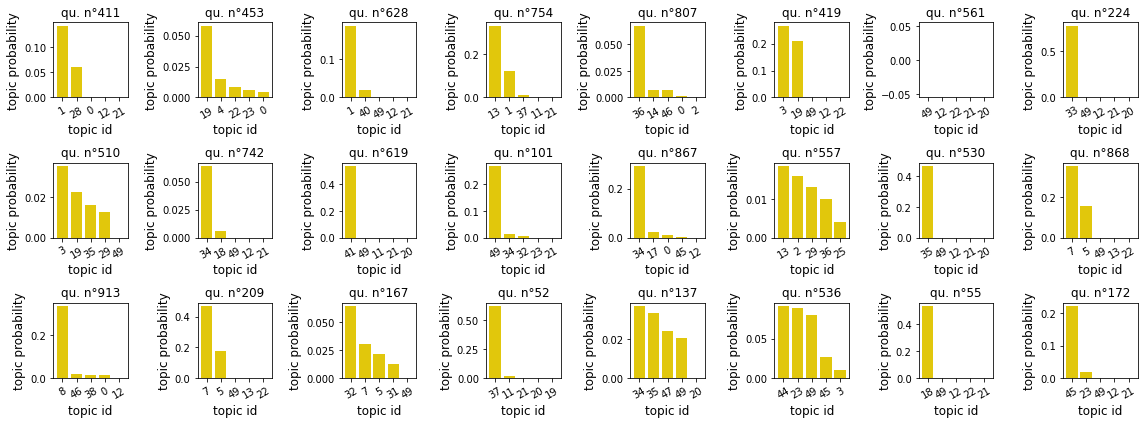

In [356]:
display_topx_topics_per_question(df_doc_topics_nmf0, ncols = 8, TopT = 5, question_min=0, nb_questions = 24, random = True)

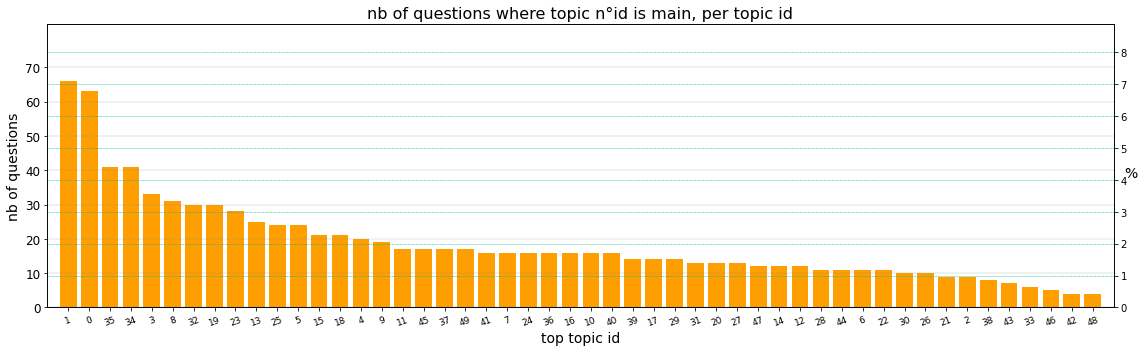

In [357]:
display_top_topic_count(df_doc_topics_nmf0, nbars = 100)

In [358]:
#topic word display

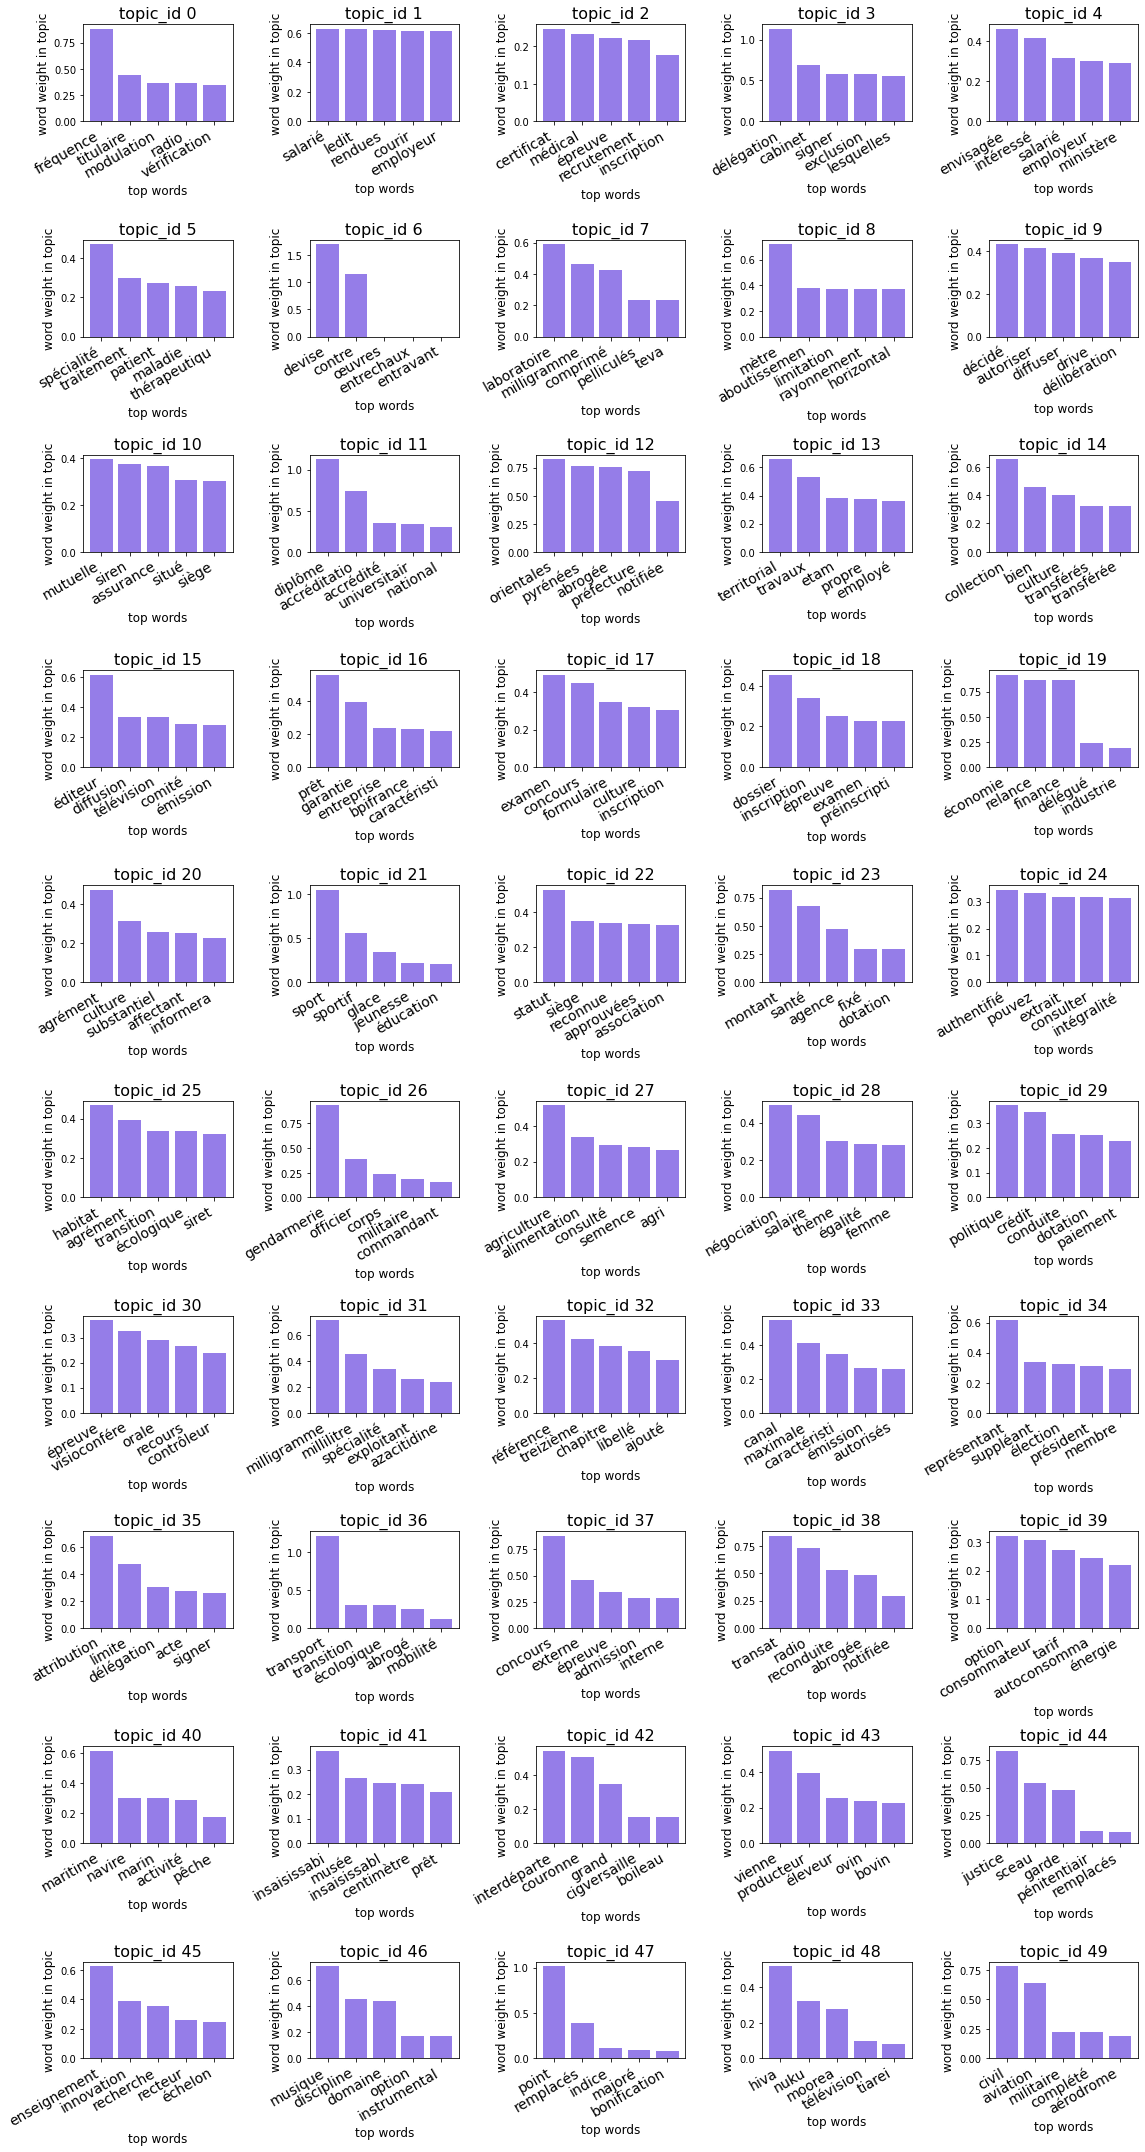

In [359]:
#display of top 5 words distribution of 10 random topics
display_topW_words_per_topic(df_topic_words_nmf0, ncols = 5, TopW = 5, topic_min=0, nb_topics = 50, random = False)

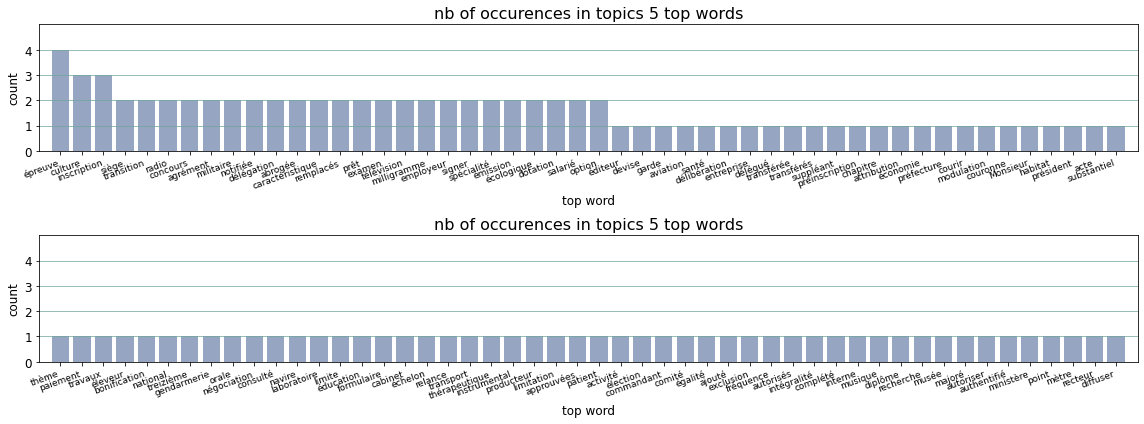

In [360]:
display_top_words_count_in_topics(df_topic_words_nmf0, nbars = 50, TOP_W = 5, nb_TOT_words=100)

In [361]:
#question (doc)/tag (word) display

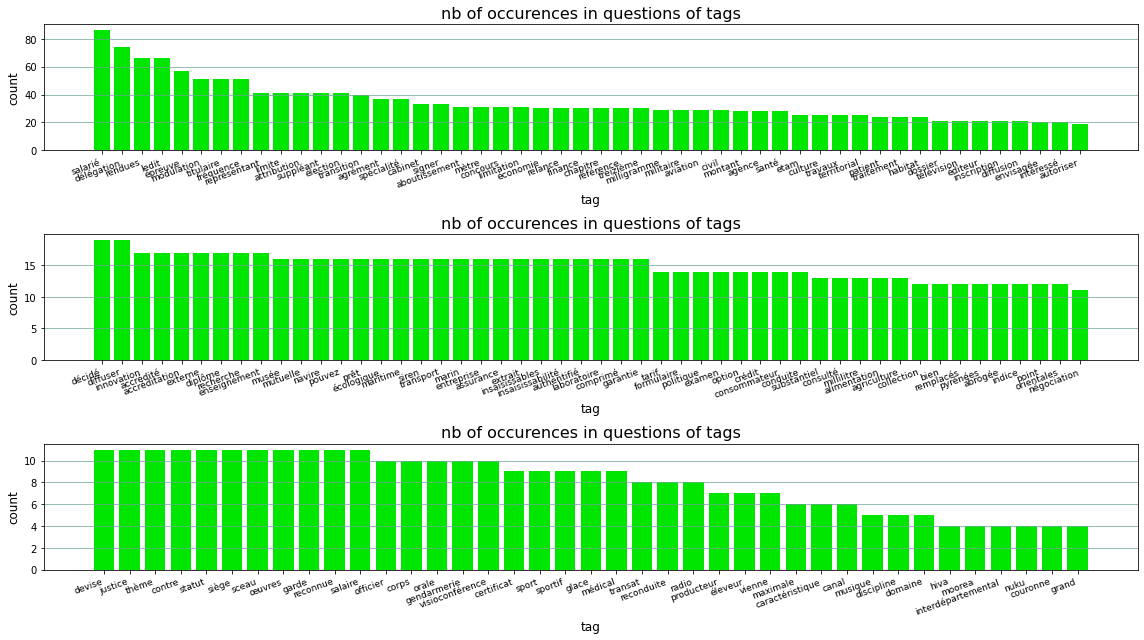

In [362]:
display_tags_count_in_questions(df_doc_topics_nmf0, df_topic_words_nmf0, nbars = 50, nb_topics = 1, nb_words = 3)

In [363]:
df_data[['doc_tokenized', 'tags_stemmed_nmf_0', 'titre_token']]

,doc_tokenized,tags_stemmed_nmf_0,titre_token
0,"[finance, garantie, paribas, crédit, lyonnais,...","[prêt, garantie, entreprise]","[accordant, garantie, paribas, crédit, lyonnai..."
1,"[comme, suit, deuxième, phrase, troisième, par...","[négociation, salaire, thème]","[modifiant, fixant, enseignement, scientifique..."
2,"[commissaire, jean, roch, état, major, particu...","[authentifié, pouvez, extrait]","[portant, nomination, présidence]"
3,"[ligne, langue, littérature, culture, étranger...","[point, remplacés, indice]","[modifiant, nature, épreuve, terminale, baccal..."
4,"[entrent, vigueur, compter, rentrée, scolaire]","[salarié, ledit, rendues]","[modifiant, fixant, enseignement, école, mater..."
...,...,...,...
925,"[mutualité, mutuelle, mutuelle, constructeur, ...","[mutuelle, siren, assurance]","[transfert, portefeuille, bulletin, adhésion, ..."
926,"[mutualité, union, mutuelle, union, mutuelle, ...","[mutuelle, siren, assurance]","[fusion, transfert, portefeuille, bulletin, ad..."
927,"[prendre, rendre, obligatoires, employeur, sal...","[envisagée, intéressé, salarié]","[conclu, cadre, entreprise, artistiques, cultu..."
928,"[prendre, rendre, obligatoires, employeur, sal...","[envisagée, intéressé, salarié]","[conclu, secteur, industrie, maroquinerie, voy..."


In [364]:
df_data

,name_file,content,id,emetteur,nature,titre,doc_tokenized,titre_token,tags_stemmed_nmf_0
0,JORFTEXT000042157732.txt,en application des \ndispositions de l'article...,JORFTEXT000042157732,"Ministère de l'économie, des finances et de la...",ARRETE,arrêté du 13 juillet 2020 accordant la garanti...,"[finance, garantie, paribas, crédit, lyonnais,...","[accordant, garantie, paribas, crédit, lyonnai...","[prêt, garantie, entreprise]"
1,JORFTEXT000042157705.txt,l'annexe de l'arrêté du 17 janvier 2019 susvis...,JORFTEXT000042157705,"Ministère de l'éducation nationale, de la jeun...",ARRETE,arrêté du 17 juillet 2020 modifiant l'arrêté d...,"[comme, suit, deuxième, phrase, troisième, par...","[modifiant, fixant, enseignement, scientifique...","[négociation, salaire, thème]"
2,JORFTEXT000042157644.txt,le commissaire en chef de 1re classe jean le r...,JORFTEXT000042157644,NaN,ARRETE,arrêté du 27 juillet 2020 portant nomination à...,"[commissaire, jean, roch, état, major, particu...","[portant, nomination, présidence]","[authentifié, pouvez, extrait]"
3,JORFTEXT000042157698.txt,a l'article 1er de l'arrêté du 22 juillet 2019...,JORFTEXT000042157698,"Ministère de l'éducation nationale, de la jeun...",ARRETE,arrêté du 17 juillet 2020 modifiant l'arrêté d...,"[ligne, langue, littérature, culture, étranger...","[modifiant, nature, épreuve, terminale, baccal...","[point, remplacés, indice]"
4,JORFTEXT000042157710.txt,l'annexe de l'arrêté du 18 février 2015 susvis...,JORFTEXT000042157710,"Ministère de l'éducation nationale, de la jeun...",ARRETE,arrêté du 17 juillet 2020 modifiant l'arrêté d...,"[entrent, vigueur, compter, rentrée, scolaire]","[modifiant, fixant, enseignement, école, mater...","[salarié, ledit, rendues]"
...,...,...,...,...,...,...,...,...,...
925,JORFTEXT000042220181.txt,par application des \ndispositions de l'articl...,JORFTEXT000042220181,Autorité de contrôle prudentiel,AVIS,avis relatif à un transfert de portefeuille de...,"[mutualité, mutuelle, mutuelle, constructeur, ...","[transfert, portefeuille, bulletin, adhésion, ...","[mutuelle, siren, assurance]"
926,JORFTEXT000042220177.txt,par application des dispositions des articles ...,JORFTEXT000042220177,Autorité de contrôle prudentiel,AVIS,avis relatif à une fusion avec transfert de po...,"[mutualité, union, mutuelle, union, mutuelle, ...","[fusion, transfert, portefeuille, bulletin, ad...","[mutuelle, siren, assurance]"
927,JORFTEXT000042220140.txt,en application de l'\narticle l. 2261-15 du co...,JORFTEXT000042220140,"Ministère du travail, de l'emploi et de l'inse...",AVIS,avis relatif à l'extension d'un avenant à un a...,"[prendre, rendre, obligatoires, employeur, sal...","[conclu, cadre, entreprise, artistiques, cultu...","[envisagée, intéressé, salarié]"
928,JORFTEXT000042220134.txt,en application de l'\narticle l. 2261-15 du co...,JORFTEXT000042220134,"Ministère du travail, de l'emploi et de l'inse...",AVIS,avis relatif à l'extension d'un accord conclu ...,"[prendre, rendre, obligatoires, employeur, sal...","[conclu, secteur, industrie, maroquinerie, voy...","[envisagée, intéressé, salarié]"


## NMP optimization : loop (gridsearch like to minimize the loss function)

In [276]:
n_topics_list = [5, 10, 30, 50, 70, 100]
alpha_list = [0,0.1, 0.5,1,2,5,10]
l1_ratio_list   = np.arange(0,1.1,0.2)
beta_loss_list = ['frobenius', 'kullback-leibler']
solver_list=['cd', 'mu']

In [ ]:
nmf_= []
nfm_err_ = []

d_hyperparam = pd.DataFrame(columns=['n_topics', 'bl', 'solver', 'alpha', 'l1r', 'nmf_err'])
i=1

text_init='{0}/{1} _ n_topics: {2}, beta_loss: {3},' + \
        ' solver: {4}, alpha: {5}, l1_r: {6:.1f}, nmf_err: {7:.2f}, time_elapsed: {8:.2f} min.'

with warnings.catch_warnings():
    # this will suppress all warnings in this block
    warnings.simplefilter("ignore")

    # NMF decomposition : Matrix = W * H + alpha * (l1_ratio * (||W|| + ||H||) + (1-l1_ratio)(||W||² + ||H||²))
    for n_topics in n_topics_list:
        for bl in beta_loss_list :
            for solver in solver_list:
                if not(solver == 'cd' and bl == 'kullback-leibler'): #only 'mu' solver works with k-l beta loss function
                    for alpha in alpha_list:
                        l1_ratio_list_ = [0] if alpha == 0 else l1_ratio_list

                        for l1r in l1_ratio_list_:
                            st=time.time()
                            nmf = NMF(n_components = n_topics, random_state=0, beta_loss = bl, max_iter = 200, solver = solver,
                                  alpha = alpha, l1_ratio = l1r).fit(tfidf)

                            nmf_.append(nmf)
                            nmf_err = nmf.reconstruction_err_
                            if alpha == 0: 
                                l1r = '_ ' 
                                text_='{0}/{1} _ n_topics: {2}, beta_loss: {3},' + \
                                    'solver: {4}, alpha: {5}, l1_r: {6}, nmf_err: {7:.2f}, time_elapsed: {8:.2f} min.'
                            else: text_=text_init
                            d_hyperparam = d_hyperparam.append({'n_topics': n_topics,'bl': bl, 'solver': solver, 
                                                                'alpha': alpha, 'l1r': l1r, 
                                                                'nmf_err': nmf_err}, ignore_index = True)
                            t_e = (time.time() - st)/60

                            print(text_.format(i, n_tries, n_topics, bl, solver, alpha, l1r, nmf_err, t_e))
                            i += 1

In [278]:
d_hyperparam

,n_topics,bl,solver,alpha,l1r,nmf_err
0,5,frobenius,cd,0,_,28.568433
1,5,frobenius,cd,0.1,0,28.569307
2,5,frobenius,cd,0.1,0.2,28.589339
3,5,frobenius,cd,0.1,0.4,28.626732
4,5,frobenius,cd,0.1,0.6,28.656108
...,...,...,...,...,...,...
661,100,kullback-leibler,mu,10,0.2,129.615739
662,100,kullback-leibler,mu,10,0.4,134.337589
663,100,kullback-leibler,mu,10,0.6,140.036718
664,100,kullback-leibler,mu,10,0.8,145.883560


In [279]:
#we look for the min of nmf_err
nmf_err_min = d_hyperparam.nmf_err.min()
ind_min = d_hyperparam.query("nmf_err == " + str(nmf_err_min)).index[0]

nmf1 = nmf_[ind_min] #best algorithm
d_hyperparam.loc[ind_min,:]

n_topics          100
bl          frobenius
solver             cd
alpha               0
l1r                _ 
nmf_err       22.5796
Name: 555, dtype: object

In [366]:
nmf1 = NMF(n_components = 100, random_state=0, beta_loss = 'frobenius', max_iter = 200, solver = 'cd',
                                  alpha = 0).fit(tfidf)

In [367]:
nmf1.reconstruction_err_

22.579625548962312

In [379]:
H=nmf1.components_

In [380]:
W = nmf1.transform(tfidf)

#matrix document/topics
df_doc_topics_nmf1  = pd.DataFrame(W)
#matrix topics/words
df_topic_words_nmf1 = pd.DataFrame(H, columns=list_words)

In [381]:
df_data['tags_stemmed_nmf_1'] = df_data.reset_index()['index'].apply(
    lambda x: retrieve_tags_from_question(x, df_doc_topics_nmf1, df_topic_words_nmf1, nb_topics = 1, nb_words = 3))

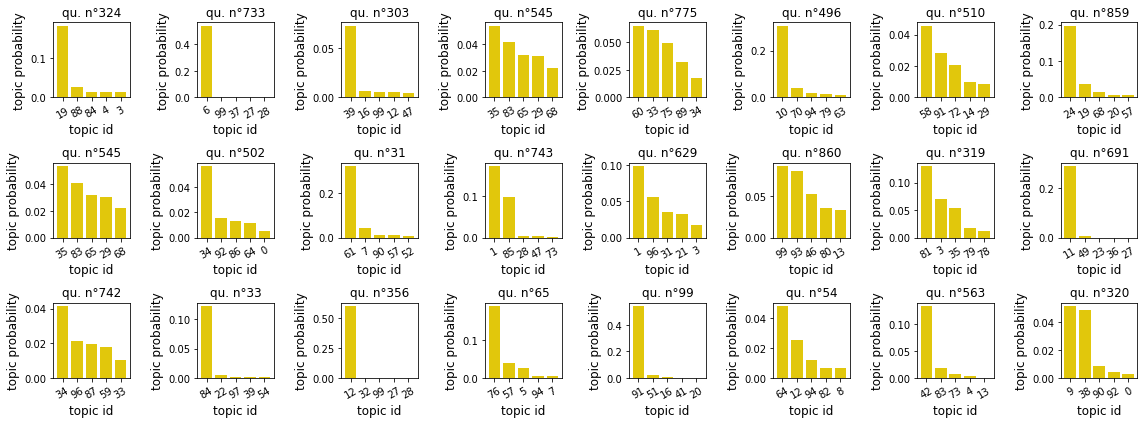

In [370]:
display_topx_topics_per_question(df_doc_topics_nmf1, ncols = 8, TopT = 5, question_min=0, nb_questions = 24, random = True)

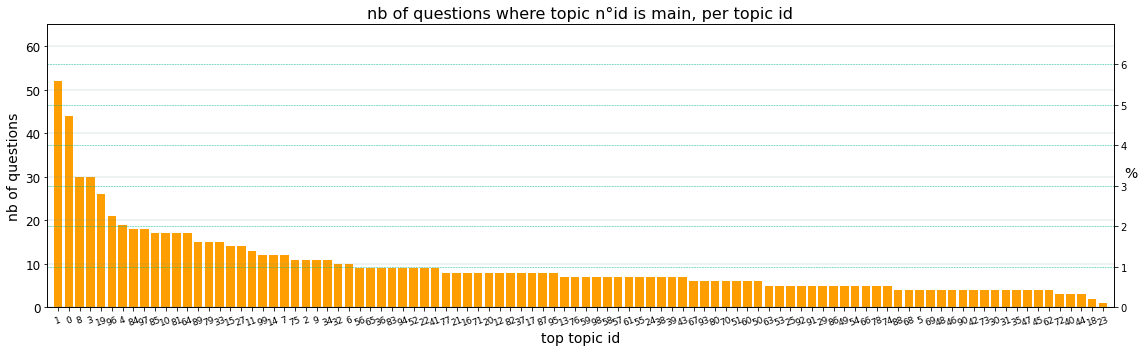

In [382]:
display_top_topic_count(df_doc_topics_nmf1, nbars = 100)

In [383]:
#topic word display

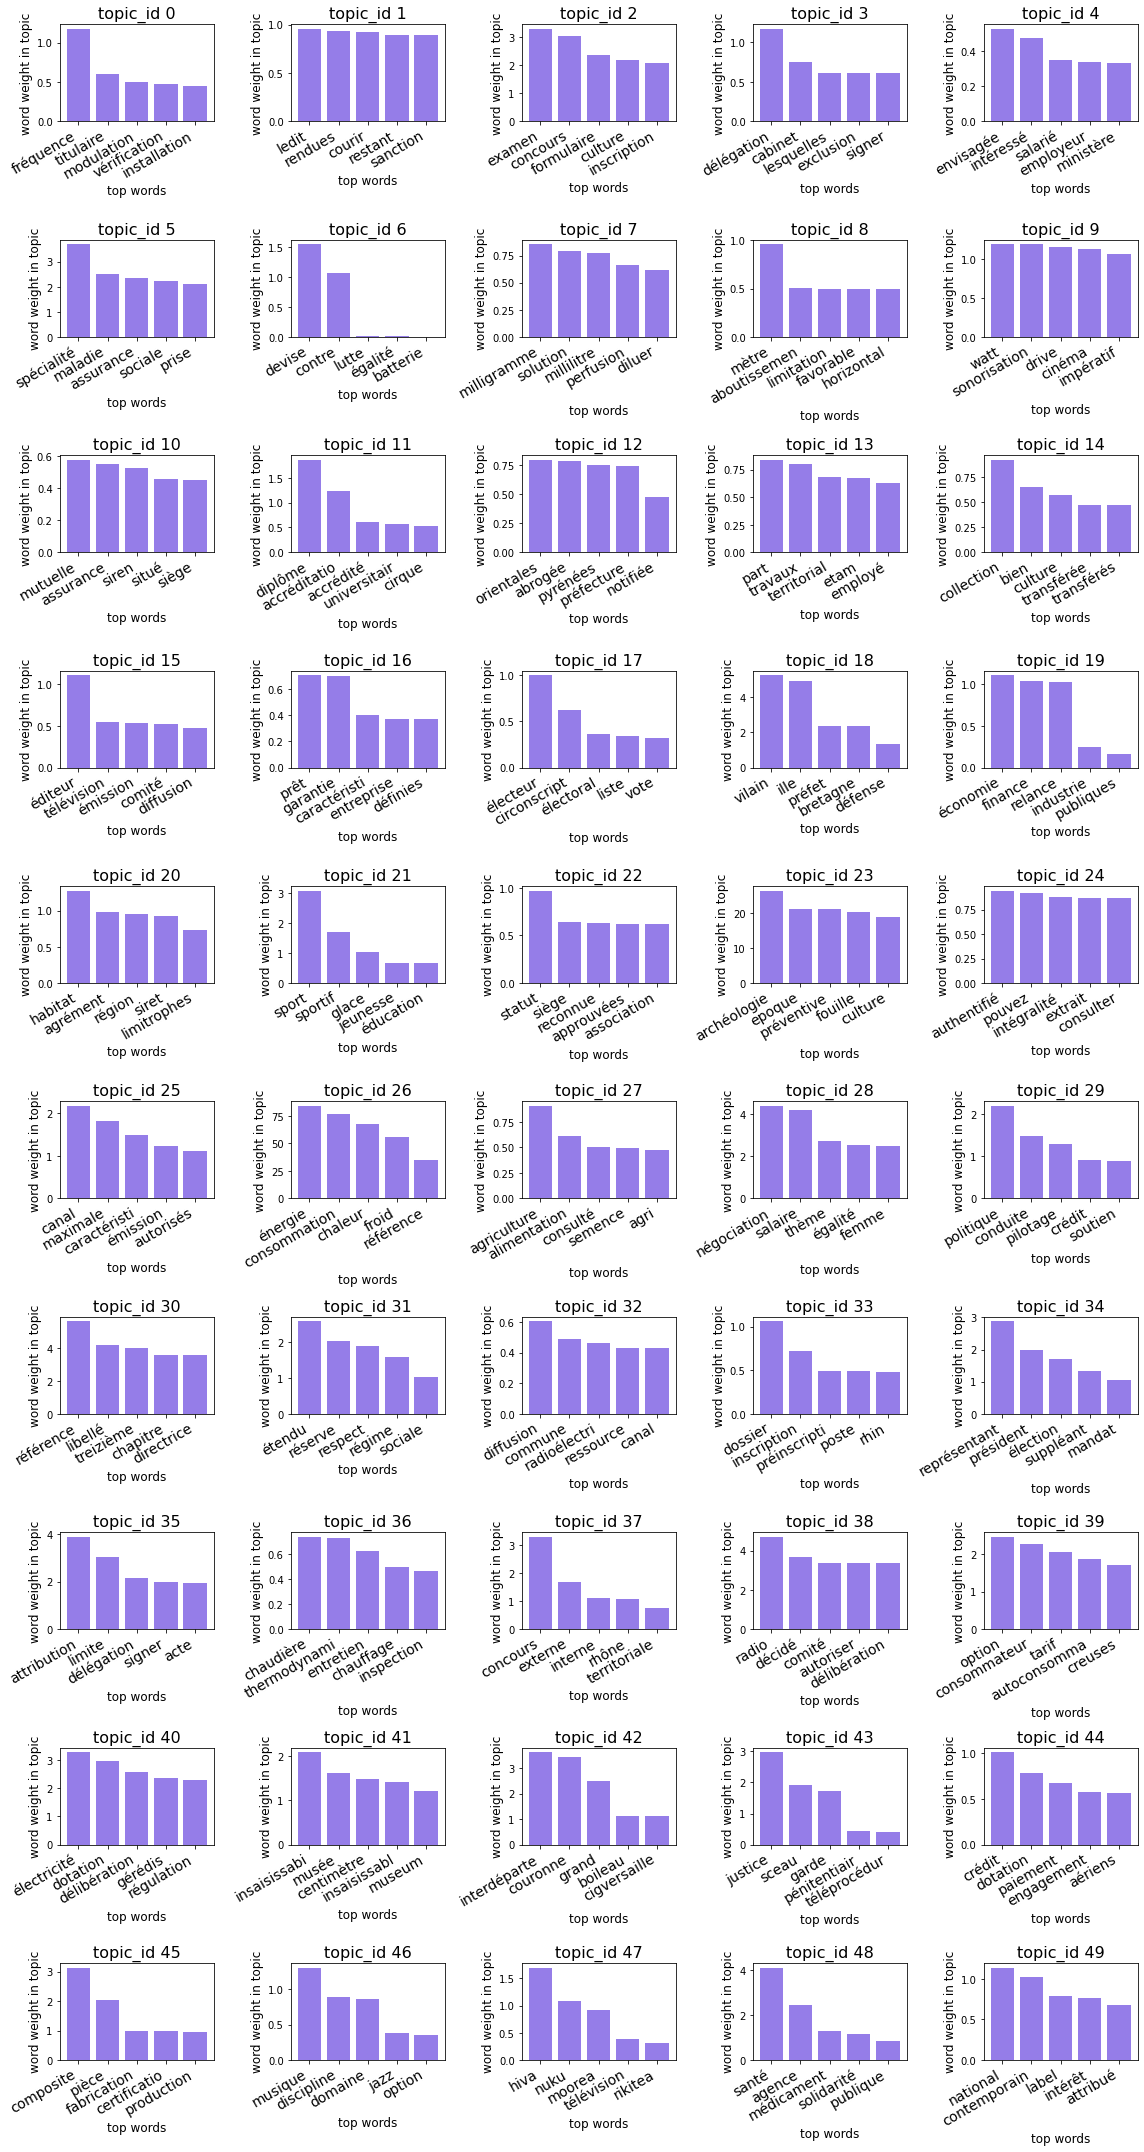

In [384]:
#display of top 5 words distribution of 10 random topics
display_topW_words_per_topic(df_topic_words_nmf1, ncols = 5, TopW = 5, topic_min=0, nb_topics = 50, random = False)

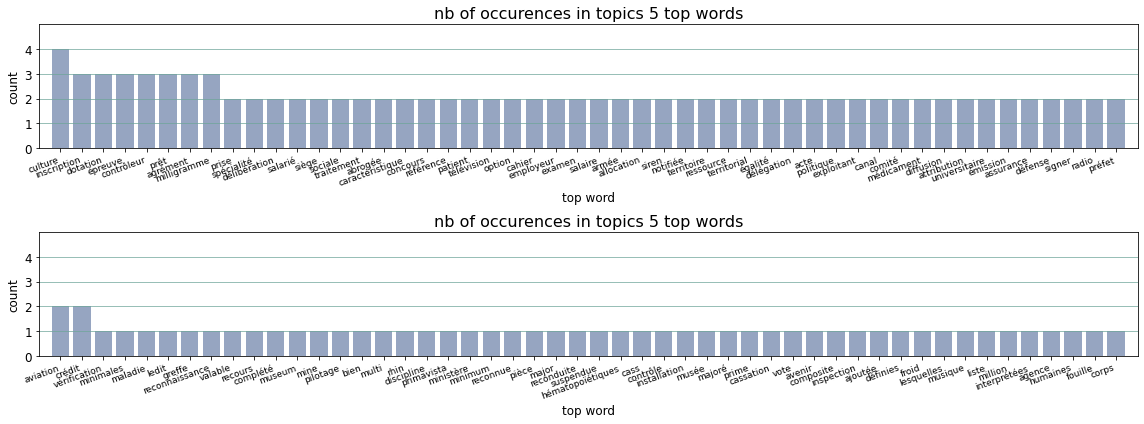

In [385]:
display_top_words_count_in_topics(df_topic_words_nmf1, nbars = 50, TOP_W = 5, nb_TOT_words=100)

In [374]:
#question (doc)/tag (word) display

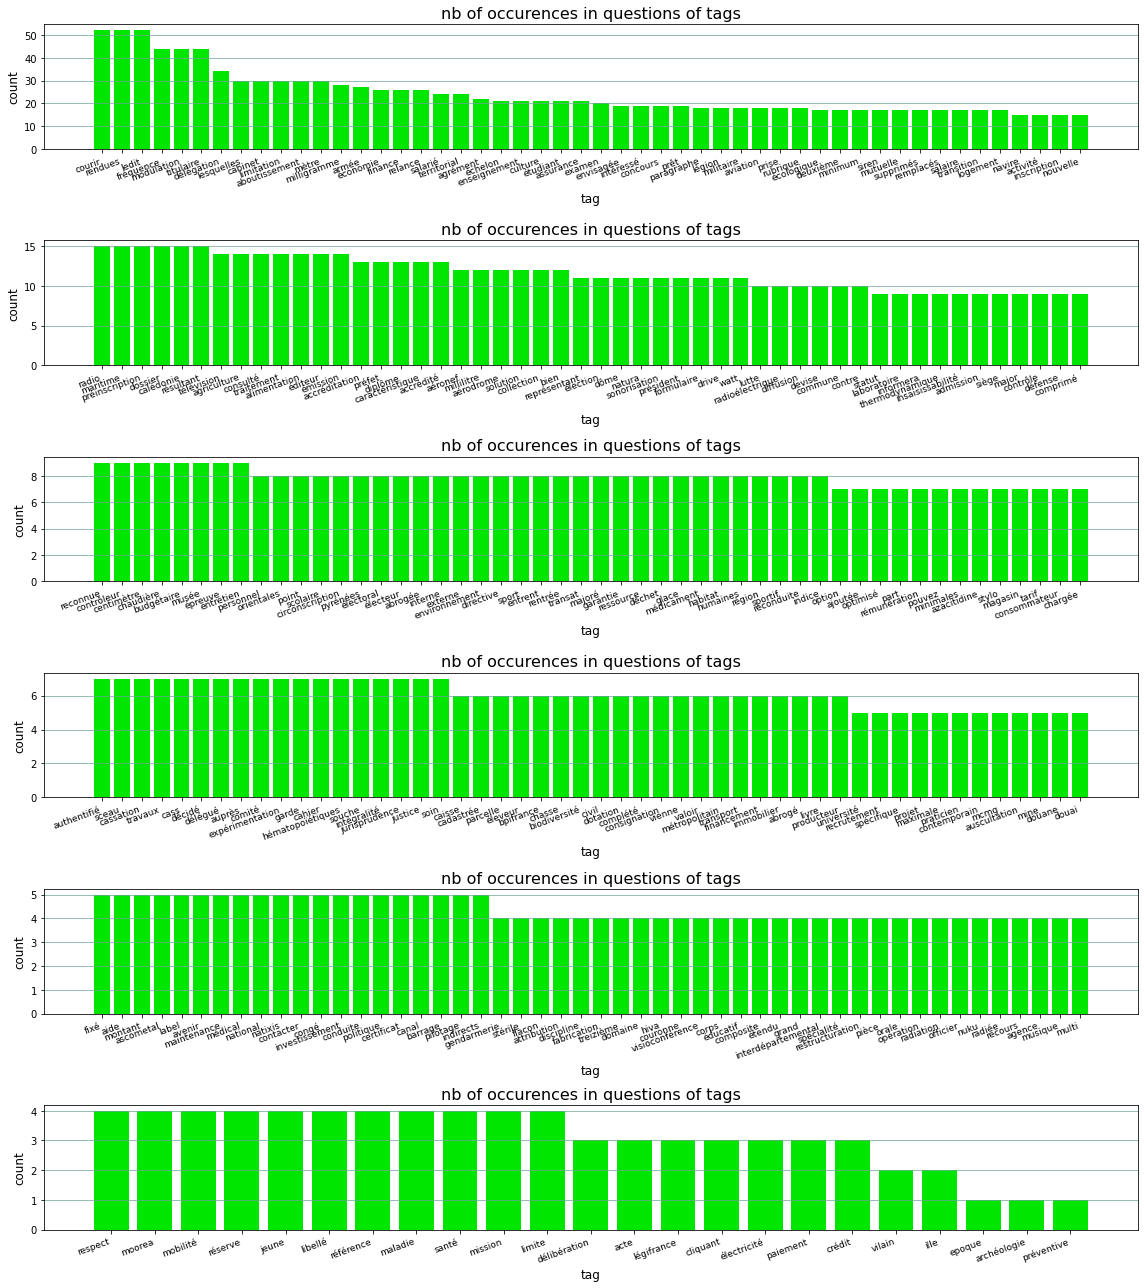

In [386]:
display_tags_count_in_questions(df_doc_topics_nmf1, df_topic_words_nmf1, nbars = 50, nb_topics = 1, nb_words = 3)

# Final results

In [387]:
#stored in tags_stemmed_nmf_1
df_data[['doc_tokenized', 'tags_stemmed_nmf_0', 'tags_stemmed_nmf_1', 'titre_token']]

,doc_tokenized,tags_stemmed_nmf_0,tags_stemmed_nmf_1,titre_token
0,"[finance, garantie, paribas, crédit, lyonnais,...","[prêt, garantie, entreprise]","[prêt, garantie, caractéristique]","[accordant, garantie, paribas, crédit, lyonnai..."
1,"[comme, suit, deuxième, phrase, troisième, par...","[négociation, salaire, thème]","[remplacés, supprimés, deuxième]","[modifiant, fixant, enseignement, scientifique..."
2,"[commissaire, jean, roch, état, major, particu...","[authentifié, pouvez, extrait]","[défense, major, armée]","[portant, nomination, présidence]"
3,"[ligne, langue, littérature, culture, étranger...","[point, remplacés, indice]","[calédonie, nouvelle, résultant]","[modifiant, nature, épreuve, terminale, baccal..."
4,"[entrent, vigueur, compter, rentrée, scolaire]","[salarié, ledit, rendues]","[rentrée, scolaire, entrent]","[modifiant, fixant, enseignement, école, mater..."
...,...,...,...,...
925,"[mutualité, mutuelle, mutuelle, constructeur, ...","[mutuelle, siren, assurance]","[mutuelle, assurance, siren]","[transfert, portefeuille, bulletin, adhésion, ..."
926,"[mutualité, union, mutuelle, union, mutuelle, ...","[mutuelle, siren, assurance]","[mutuelle, assurance, siren]","[fusion, transfert, portefeuille, bulletin, ad..."
927,"[prendre, rendre, obligatoires, employeur, sal...","[envisagée, intéressé, salarié]","[envisagée, intéressé, salarié]","[conclu, cadre, entreprise, artistiques, cultu..."
928,"[prendre, rendre, obligatoires, employeur, sal...","[envisagée, intéressé, salarié]","[envisagée, intéressé, salarié]","[conclu, secteur, industrie, maroquinerie, voy..."


In [391]:
df_doc_tags = df_data.reset_index()['index'].apply(
        lambda x: retrieve_tags_from_question(x, df_doc_topics_nmf1, df_topic_words_nmf1, nb_topics = 1, nb_words = 3)
        ).reset_index()
df_doc_tags.columns = ['doc_id', 'Tags']
df_doc_tags_        = pd.DataFrame(df_doc_tags.Tags.explode())
df_doc_tags_['Count_Tags'] = 1
df_countTags       = df_doc_tags_.groupby('Tags').count().sort_values(by='Count_Tags', ascending = False).reset_index()
#df_countTags has one columns 'Tags' and the other 'Count_Tags'b

**Export to a csv file**

In [393]:
df_countTags.to_csv(os.path.join(my_path_csv, 'count_tags_1000_documents.csv'))